In [1]:
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import sklearn
import sklearn.model_selection
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#agg_tab_path = f'{os.path.expanduser("~")}\\IconPro GmbH\\IconPro GmbH - Dokumente\\50 Research Projects\\03 Aniara\\Data\\01_Processed_Data\\03_master\\agg_table.csv'
agg_tab_path = f'{os.path.expanduser("~")}\\IconPro GmbH\\IconPro GmbH - Dokumente\\40 Projects\\035 Talos\\Client data\\Brampton\\Gas\\Master\\agg_gas_table.csv'
if 'csv' in agg_tab_path:
    agg_tab = pd.read_csv(agg_tab_path)
else:
    agg_tab = pd.read_excel(agg_tab_path)

# def select_measure(agg_table: pd.DataFrame, measure: str):
#     t = agg_table[agg_table['Measure'] == measure]
#     t = pd.get_dummies(t, columns = ['day_of_week'], drop_first=True)
#     t = t[(t['production']==True) & (t['heating_degree_hours'] > 0)]
#         # filter data out by year
#     t['year_2018'] = [('2018' in date) for date in t['date'].values]
#     t['production'] = t['production'].astype(int).values
#     t.replace({True:1, False:0}, inplace=True)
#     t18, t21 =  t[t['year_2018'] == 1].copy(), t[t['year_2018'] == 0].copy()
#     t18 = t18.dropna()
#     t21 = t21.dropna()
#     return t18, t21

In [3]:
def select_measure(agg_table: pd.DataFrame, measure: str):
    t = agg_table[agg_table['Measure'] == measure]
    t = pd.get_dummies(t, columns = ['day_of_week'])#, drop_first=True)
    t = t[(t['production']==True) & (t['heating_degree_hours'] > 0)]
    t = t[t['consumption'] > (t['consumption'].mean() - 2*(t['consumption'].std()))]
    t.replace({True:1, False:0}, inplace=True)
    t = t.dropna()
    return t

In [4]:
def univariate_model(df: pd.DataFrame):
    Y, X = df['consumption'], df['mean_temp']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    res = model.fit()
    print(res.summary())
    return res

In [5]:
# empirical results, reference: https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule
def std_to_alpha(std: float):
    std = abs(std)
    if std >= 3:
        return 0.0027
    if std >= 2.5:
        return 0.01242
    if std >= 2:
        return 0.0455
    if std >= 1.5:
        return 0.1336
    if std >= 1:
        return 0.3173
    if std >= 0.5:
        return 0.6171
    else:
        return 0.9

In [6]:
def get_overcon(df: pd.DataFrame, res: sm.regression.linear_model.RegressionResultsWrapper, alpha: float):
    pred_ols = res.get_prediction()
    
    # classification, over-consumption: True, otherwise: False
    lo_bound, up_bound = pred_ols.summary_frame(alpha=alpha)[['obs_ci_lower']], pred_ols.summary_frame(alpha=alpha)[['obs_ci_upper']]
    df['lo'] = lo_bound
    df['up'] = up_bound
    df['over_con'] = df['consumption'] > df['up']
    return df[df['over_con'] == True]

In [7]:
# K-fold CV
def prepare_kfold_cv(df: pd.DataFrame, features: list):
    df = df[features].copy()
    df.replace({True:1, False:0}, inplace=True)
    df_train, df_test = train_test_split(df.dropna(), 
                                         train_size = 0.8, 
                                         test_size = 0.2, 
                                         random_state = 100)
    # split into X and y for both train and test sets
    y_train = df_train.pop('consumption')
    X_train = df_train
    y_test = df_test.pop('consumption')
    X_test = df_test
    return X_train, y_train, X_test, y_test

In [8]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
# https://www.kaggle.com/code/jnikhilsai/cross-validation-with-linear-regression
def select_model_cv(X_train: pd.DataFrame, y_train: pd.DataFrame, n_features_optimal: int):
    # step-1: create a cross-validation scheme
    #folds = KFold(n_splits = 5, shuffle = True, random_state = 11)
    rkf = sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
    # step-2: specify range of hyperparameters to tune
    hyper_params = [{'n_features_to_select': list(range(1, n_features_optimal))}]


    # step-3: perform grid search
    # 3.1 specify model
    #lm = LinearRegression()
    #lm.fit(X_train, y_train)
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    rfe = RFE(ridge)             

    # 3.2 call GridSearchCV()
    model_cv = GridSearchCV(estimator = rfe, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = rkf, #folds, 
                            verbose = 0,
                            return_train_score=True)      

    # fit the model
    model_cv.fit(X_train, y_train)
    return model_cv

In [9]:
def select_n_features_optimal(model_cv: sklearn.model_selection._search.GridSearchCV):
    cv_results = pd.DataFrame(model_cv.cv_results_)
    return cv_results[cv_results['rank_test_score'] == 1]['param_n_features_to_select'].min()

In [10]:
def select_features(X_train: pd.DataFrame, y_train: pd.DataFrame, n_features_optimal: int):
    # rfe = RFE(LinearRegression(), n_features_to_select=n_features_optimal)
    # Ridge Regression
    rfe = RFE(Ridge(), n_features_to_select=n_features_optimal, step=1)
    rfe = rfe.fit(X_train, y_train)
    features = list(zip(X_train.columns, rfe.support_, rfe.ranking_)) # True 1 is selected
    fs = [f for f, s, r in features if (s==True and r==1)]
    return fs

In [11]:
def plot_feature_importance_ridgecv(X_train: pd.DataFrame, y_train: pd.DataFrame):
    ridge = RidgeCV().fit(X_train, y_train)
    importance = np.abs(ridge.coef_)
    feature_names = np.array(X_train.columns)
    plt.bar(height=importance, x=feature_names)
    plt.title("Feature importances via coefficients")
    ax = plt.gca()
    x_labels = [str(i) for i in range(len(X_train.columns))]
    plt.xticks(ticks = list(range(len(X_train.columns))), labels = x_labels)
    plt.show()
    return ridge, importance, feature_names

In [12]:
def select_features_ridgecv(X_train: pd.DataFrame, y_train: pd.DataFrame, n_features_optimal: int):
    ridge, importance, feature_names = plot_feature_importance_ridgecv(X_train, y_train)
    threshold = np.sort(importance)[-n_features_optimal-1] + 0.01
    sfm = SelectFromModel(ridge, threshold=threshold).fit(X_train, y_train)
    fs = feature_names[sfm.get_support()]
    print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
    return fs

In [13]:
def test_kfold_cv(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, n_features_optimal: int):
    lm = LinearRegression().fit(X_train, y_train)
    # predict of X_test
    y_pred = lm.predict(X_test)
    r2 = sklearn.metrics.r2_score(y_test, y_pred)
    print(r2)

In [14]:
def multivariate_model(df: pd.DataFrame, features: list):
    df = df.dropna()
    Y, X = df['consumption'], df[features]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    res = model.fit() #model.fit_regularized()
    print(res.summary())
    return res

In [15]:
def plot_overcon(df: pd.DataFrame, m1: sm.regression.linear_model.RegressionResultsWrapper, 
                 overcon: pd.DataFrame, alpha: float):
    x = df['mean_temp']
    Y = df['consumption']
    pred_ols = m1.get_prediction()
    iv_l = pred_ols.summary_frame(alpha=alpha)["obs_ci_lower"]
    iv_u = pred_ols.summary_frame(alpha=alpha)["obs_ci_upper"]
    # classification, over-consumption: True, otherwise: False
    lo_bound, up_bound = pred_ols.summary_frame(alpha=alpha)[['obs_ci_lower']], pred_ols.summary_frame(alpha=alpha)[['obs_ci_upper']]
    df['lo'] = lo_bound
    df['up'] = up_bound
    df['over_con'] = [int(i in overcon.index) for i in df.index]

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(x, Y, "o", label="data")
    ax.plot(x, m1.fittedvalues, "r", label="OLS")
    ax.plot(x, iv_u, "y--", label="upper")
    ax.plot(x, iv_l, "g--", label="lower")
    yo = df[df['over_con'] == True][['mean_temp', 'consumption']]
    ax.plot(yo['mean_temp'].values, yo['consumption'].values, 'o', label='over consumption')
    ax.legend(loc="best")

In [16]:
def get_metrics(df: pd.DataFrame, features: list):
    Y, X = df['consumption'], df[features]
    rkf = sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
    regr = linear_model.LinearRegression()
    scores = cross_validate(regr, X, Y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                                   'neg_mean_absolute_percentage_error'))
    metrics = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[scores['test_neg_mean_absolute_error'].mean()], 
              'rmse':[scores['test_neg_root_mean_squared_error'].mean()],
              'mape':[scores['test_neg_mean_absolute_percentage_error'].mean()]})
    return metrics

In [17]:
def run(df: pd.DataFrame, std: float):
    alpha = std_to_alpha(std)
    m1 = univariate_model(df)
    overcon_m1 = get_overcon(df, m1, alpha)
    fs0 = ['mean_temp', 'consumption', 'heating_degree_hours',
           'day', 'week', 'production', 'morning_temp', 'afternoon_temp',
           'evening_temp', 'mean_temp_prev_1', 'morning_temp_prev_1',
           'afternoon_temp_prev_1', 'evening_temp_prev_1',
           'heating_degree_hours_prev_1', 'mean_temp_prev_2',
           'morning_temp_prev_2', 'afternoon_temp_prev_2', 'evening_temp_prev_2',
           'heating_degree_hours_prev_2', 'mean_temp_prev_3',
           'morning_temp_prev_3', 'afternoon_temp_prev_3', 'evening_temp_prev_3',
           'heating_degree_hours_prev_3', 'last_day_production',
           'last_day_consumption','day_of_week_0', 'day_of_week_1', 'day_of_week_2',
           'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']
    X_train, y_train, X_test, y_test = prepare_kfold_cv(df, fs0)
    # do cross-validation
    model_cv = select_model_cv(X_train, y_train, len(X_train.columns))
    # select the best n
    n_features_optimal = select_n_features_optimal(model_cv)
    fs = select_features(X_train, y_train, n_features_optimal)
    # select feature using ridgecv 
    # n_feature_optimal selected by looking at the plot of feature importance
    fs = select_features_ridgecv(X_train, y_train, 14)
    # test for kfold_cv
    print('result of test kfold_cv: ') 
    test_kfold_cv(X_train, y_train, X_test, y_test, n_features_optimal)
    # get over consumption
    plot_overcon(df, m1, overcon_m1, alpha)
    m2 = multivariate_model(df, fs)
    overcon_m2 = get_overcon(df, m2, alpha)
    plot_overcon(df, m1, overcon_m2, alpha)
    overcon = pd.concat([overcon_m1, overcon_m2])
    plot_overcon(df, m1, overcon, alpha)
    # get metrics
    metrics_m1, metrics_m2 = get_metrics(df, ['mean_temp']), get_metrics(df, fs)
    metrics = pd.concat([metrics_m1, metrics_m2])
    metrics = metrics.set_index(pd.Series(['m1_cv', 'm2_cv']))
    return [(m1, overcon_m1), (m2, overcon_m2), overcon, alpha, metrics]

In [18]:
def export_model(df: pd.DataFrame, m: str, results):
    if m == 'm1':
        plot_overcon(df, results[0][0], results[0][1], results[3])
        print(results[0][0].summary())
        return results[0][0], results[0][1]
    if m == 'm2':
        plot_overcon(df, results[0][0], results[1][1], results[3])
        print(results[1][0].summary())
        return results[1][0], results[1][1]
    if m == 'both':
        plot_overcon(df, results[0][0], results[2], results[3])
        return results[0][1]

                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     2010.
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          3.95e-131
Time:                        14:11:48   Log-Likelihood:                -3245.5
No. Observations:                 287   AIC:                             6495.
Df Residuals:                     285   BIC:                             6502.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.717e+05   1556.668    110.316      0.0

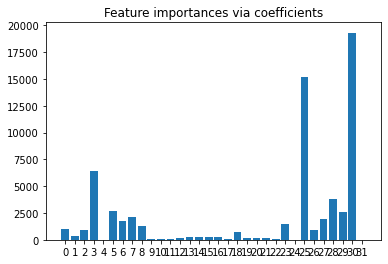

Features selected by SelectFromModel: ['mean_temp' 'day' 'week' 'morning_temp' 'afternoon_temp' 'evening_temp'
 'mean_temp_prev_1' 'last_day_production' 'day_of_week_0' 'day_of_week_1'
 'day_of_week_2' 'day_of_week_3' 'day_of_week_4' 'day_of_week_5']
result of test kfold_cv: 
0.9390152298632789
                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     253.8
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          1.13e-140
Time:                        14:12:09   Log-Likelihood:                -3186.9
No. Observations:                 287   AIC:                             6400.
Df Residuals:                     274   BIC:                             6447.
Df Model:                          12                                   

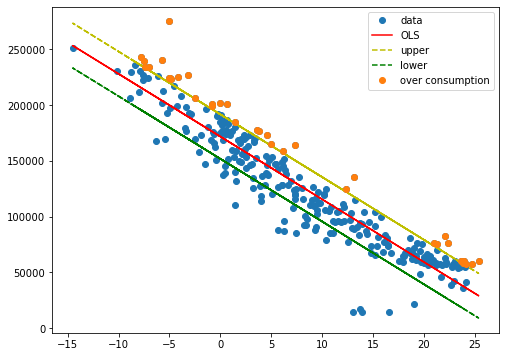

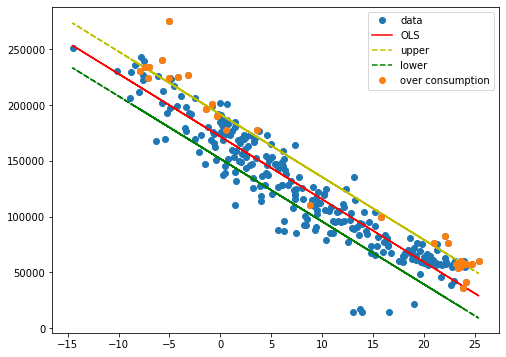

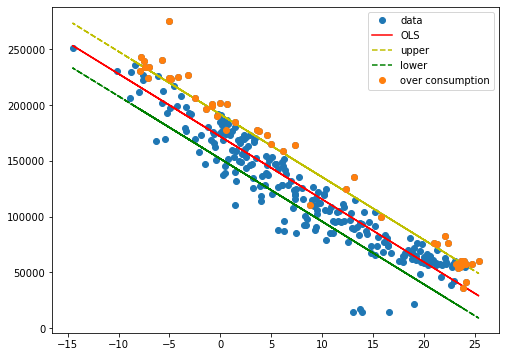

In [19]:
t = select_measure(agg_tab, 'Brampton_NGAS')
r = run(t, 1.2)

                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     2010.
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          3.95e-131
Time:                        14:12:11   Log-Likelihood:                -3245.5
No. Observations:                 287   AIC:                             6495.
Df Residuals:                     285   BIC:                             6502.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.717e+05   1556.668    110.316      0.0

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1fb239e1550>,
            Measure        date  mean_temp  consumption  heating_degree_hours  \
 28   Brampton_NGAS  2020-01-28  -0.048958   201872.625             457.17500   
 29   Brampton_NGAS  2020-01-29  -4.975521   224005.500             575.41250   
 35   Brampton_NGAS  2020-02-04   0.610417   200779.250             441.35000   
 36   Brampton_NGAS  2020-02-05  -5.089062   224361.000             578.13750   
 43   Brampton_NGAS  2020-02-12  -0.842187   201207.000             476.21250   
 44   Brampton_NGAS  2020-02-13  -5.074479   274813.125             577.78750   
 49   Brampton_NGAS  2020-02-18   1.413021   184719.125             422.08750   
 50   Brampton_NGAS  2020-02-19  -3.221354   226576.625             533.31250   
 51   Brampton_NGAS  2020-02-20  -7.465104   239557.750             635.16250   
 57   Brampton_NGAS  2020-02-26  -0.855208   199085.000             476.52500   
 58   Brampton_NGAS  2020-0

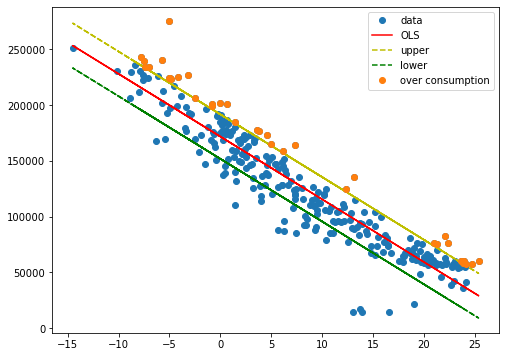

In [20]:
export_model(t, 'm1', r)

                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     253.8
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          1.13e-140
Time:                        14:12:11   Log-Likelihood:                -3186.9
No. Observations:                 287   AIC:                             6400.
Df Residuals:                     274   BIC:                             6447.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 1.46e+05   2

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1fb262408b0>,
            Measure        date  mean_temp  consumption  heating_degree_hours  \
 36   Brampton_NGAS  2020-02-05  -5.089062   224361.000             578.13750   
 43   Brampton_NGAS  2020-02-12  -0.842187   201207.000             476.21250   
 44   Brampton_NGAS  2020-02-13  -5.074479   274813.125             577.78750   
 50   Brampton_NGAS  2020-02-19  -3.221354   226576.625             533.31250   
 59   Brampton_NGAS  2020-02-28  -5.728125   240490.750             593.47500   
 161  Brampton_NGAS  2020-06-09  24.146875    57742.750              13.72500   
 162  Brampton_NGAS  2020-06-10  23.649479    59870.500               3.22500   
 178  Brampton_NGAS  2020-06-26  23.730208    57063.000              10.40000   
 181  Brampton_NGAS  2020-06-29  25.370833    59881.250               0.03750   
 197  Brampton_NGAS  2020-07-15  23.827083    58354.000               0.18125   
 210  Brampton_NGAS  2020-0

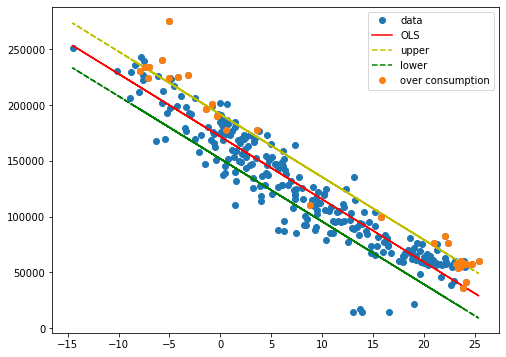

In [21]:
export_model(t, 'm2', r)

,Measure,date,mean_temp,consumption,heating_degree_hours,day,week,production,morning_temp,afternoon_temp,...,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,lo,up,over_con
28,Brampton_NGAS,2020-01-28,-0.048958,201872.625,457.17500,28,5,1,-0.081250,0.412500,...,0,1,0,0,0,0,0,152117.405158,191885.042681,True
29,Brampton_NGAS,2020-01-29,-4.975521,224005.500,575.41250,29,5,1,-3.806250,-4.952083,...,0,0,1,0,0,0,0,179757.127687,219608.429109,True
35,Brampton_NGAS,2020-02-04,0.610417,200779.250,441.35000,35,6,1,0.929167,1.369792,...,0,1,0,0,0,0,0,148416.629597,188175.976193,True
36,Brampton_NGAS,2020-02-05,-5.089062,224361.000,578.13750,36,6,1,-4.972917,-5.557292,...,0,0,1,0,0,0,0,180393.910509,220247.590652,True
43,Brampton_NGAS,2020-02-12,-0.842187,201207.000,476.21250,43,7,1,-2.256250,-0.771875,...,0,0,1,0,0,0,0,156568.988629,196347.510901,True
44,Brampton_NGAS,2020-02-13,-5.074479,274813.125,577.78750,44,7,1,-1.425000,-3.705208,...,0,0,0,1,0,0,0,180312.122457,220165.495942,True
49,Brampton_NGAS,2020-02-18,1.413021,184719.125,422.08750,49,8,1,-0.797917,2.705208,...,0,1,0,0,0,0,0,143911.509025,183661.691870,True
50,Brampton_NGAS,2020-02-19,-3.221354,226576.625,533.31250,50,8,1,-1.475000,-2.914583,...,0,0,1,0,0,0,0,169917.837383,209734.964263,True
51,Brampton_NGAS,2020-02-20,-7.465104,239557.750,635.16250,51,8,1,-7.477083,-6.637500,...,0,0,0,1,0,0,0,193717.293525,233625.392018,True
57,Brampton_NGAS,2020-02-26,-0.855208,199085.000,476.52500,57,9,1,1.804167,-1.263542,...,0,0,1,0,0,0,0,156642.057093,196420.766332,True


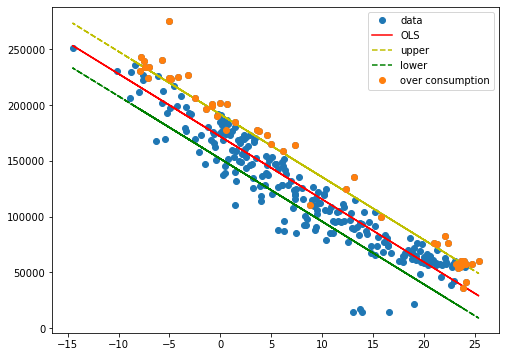

In [22]:
export_model(t, 'both', r)

In [23]:
# get metrics m1, m2
r[-1]

,r2,mae,rmse,mape
m1_cv,0.870758,-14680.892708,-19729.940331,-0.200479
m2_cv,0.906744,-11858.516607,-16721.163270,-0.181446


In [24]:
# add prection for consumption column
agg_tab['consumption_prediction'] = r[0][0].predict(sm.add_constant(agg_tab['mean_temp']))
agg_tab.to_csv(f'{os.path.expanduser("~")}\\IconPro GmbH\\IconPro GmbH - Dokumente\\40 Projects\\035 Talos\\Client data\\Brampton\\Gas\\Master\\agg_gas_with_consumption_prediction.csv', index=False)

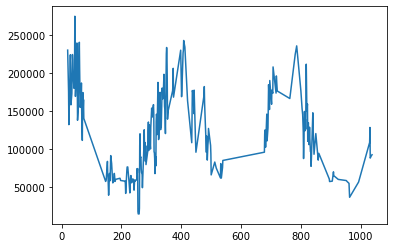

In [25]:
plt.plot(t['consumption'])

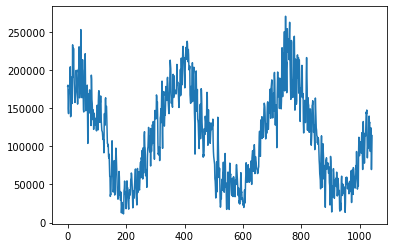

In [26]:
plt.plot(agg_tab['consumption_prediction'])

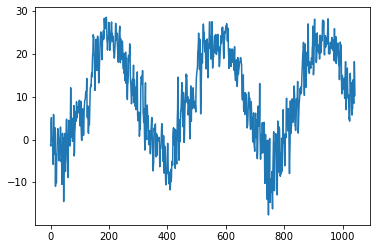

In [27]:
plt.plot(agg_tab['mean_temp'])

In [28]:
t.columns

Index(['Measure', 'date', 'mean_temp', 'consumption', 'heating_degree_hours',
       'day', 'week', 'production', 'morning_temp', 'afternoon_temp',
       'evening_temp', 'mean_temp_prev_1', 'morning_temp_prev_1',
       'afternoon_temp_prev_1', 'evening_temp_prev_1',
       'heating_degree_hours_prev_1', 'mean_temp_prev_2',
       'morning_temp_prev_2', 'afternoon_temp_prev_2', 'evening_temp_prev_2',
       'heating_degree_hours_prev_2', 'mean_temp_prev_3',
       'morning_temp_prev_3', 'afternoon_temp_prev_3', 'evening_temp_prev_3',
       'heating_degree_hours_prev_3', 'last_day_production',
       'last_day_consumption', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'lo', 'up', 'over_con'],
      dtype='object')

In [29]:
#t18, t21 = select_measure(agg_tab, 'BS_HEAT_CF')
#run(t18, 1)

In [30]:
#plt.hist(t['consumption'], bins=40)

In [31]:
#plt.hist(t21['consumption'], bins=40)